# TextureNet: Automated Surface Texture Classification for Material Analysis

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download ag3ntsp1d3rx/kth-tips-2

Dataset URL: https://www.kaggle.com/datasets/ag3ntsp1d3rx/kth-tips-2
License(s): unknown
  0% 0.00/67.7M [00:00<?, ?B/s]
100% 67.7M/67.7M [00:00<00:00, 1.76GB/s]


In [5]:
!unzip kth-tips-2.zip -d kth-tips-2

Archive:  kth-tips-2.zip
  inflating: kth-tips-2/KTH_TIPS/README.txt  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_1_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_2_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_3_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_4_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_5_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_6_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_7_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_8_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_1_im_9_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_2_im_1_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_2_im_2_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminium_foil/15-scale_2_im_3_col.png  
  inflating: kth-tips-2/KTH_TIPS/aluminiu

In [6]:
import os
import shutil
import random

source_dir = '/content/kth-tips-2/KTH_TIPS'
target_dir = '/content/kth-tips2b-split'
train_ratio = 0.8  # 80% training, 20% validation

os.makedirs(target_dir, exist_ok=True)
for split in ['train', 'val']:
    os.makedirs(os.path.join(target_dir, split), exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(len(images) * train_ratio)
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    for split, imgs in zip(['train','val'], [train_imgs, val_imgs]):
        class_split_dir = os.path.join(target_dir, split, class_name)
        os.makedirs(class_split_dir, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_split_dir, img))


In [8]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(target_dir,'train'), transform=transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(target_dir,'val'), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


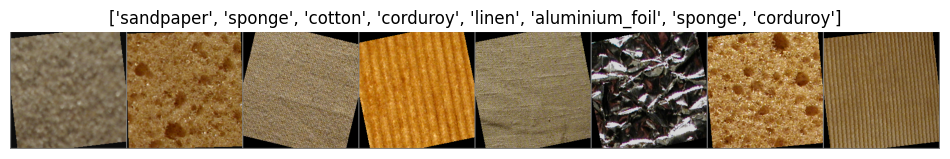

In [13]:
import torchvision

def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(12,6))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show 8 random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), title=[train_dataset.classes[i] for i in labels[:8]])


# Define CNN – Transfer Learning (ResNet18)

In [14]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs,1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} Val Acc: {val_acc:.2f}%")



Epoch [1/10] Train Loss: 0.9488 Val Loss: 66.0462 Val Acc: 40.59%
Epoch [2/10] Train Loss: 0.6253 Val Loss: 2.0751 Val Acc: 75.88%
Epoch [3/10] Train Loss: 0.3821 Val Loss: 0.1477 Val Acc: 95.29%
Epoch [4/10] Train Loss: 0.2959 Val Loss: 0.2190 Val Acc: 91.18%
Epoch [5/10] Train Loss: 0.2156 Val Loss: 0.0575 Val Acc: 98.24%
Epoch [6/10] Train Loss: 0.3188 Val Loss: 0.1180 Val Acc: 96.47%
Epoch [7/10] Train Loss: 0.1886 Val Loss: 0.1072 Val Acc: 98.24%
Epoch [8/10] Train Loss: 0.1662 Val Loss: 0.0863 Val Acc: 96.47%
Epoch [9/10] Train Loss: 0.3797 Val Loss: 0.2100 Val Acc: 92.35%
Epoch [10/10] Train Loss: 0.2643 Val Loss: 1.0791 Val Acc: 80.59%


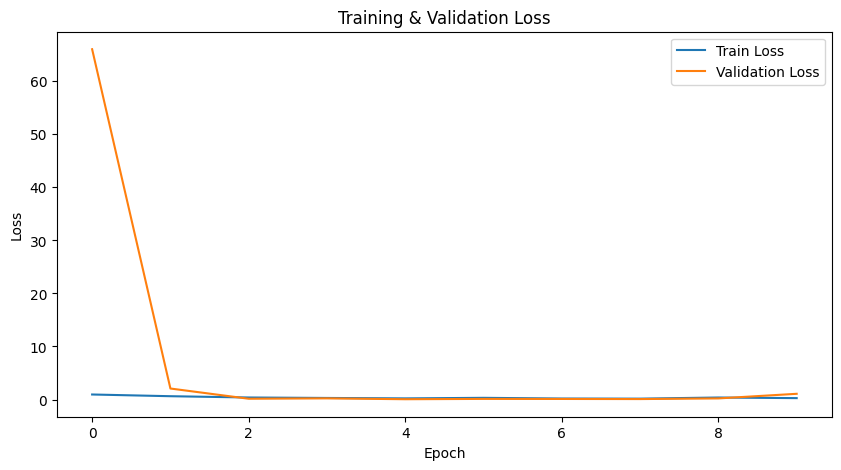

In [17]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

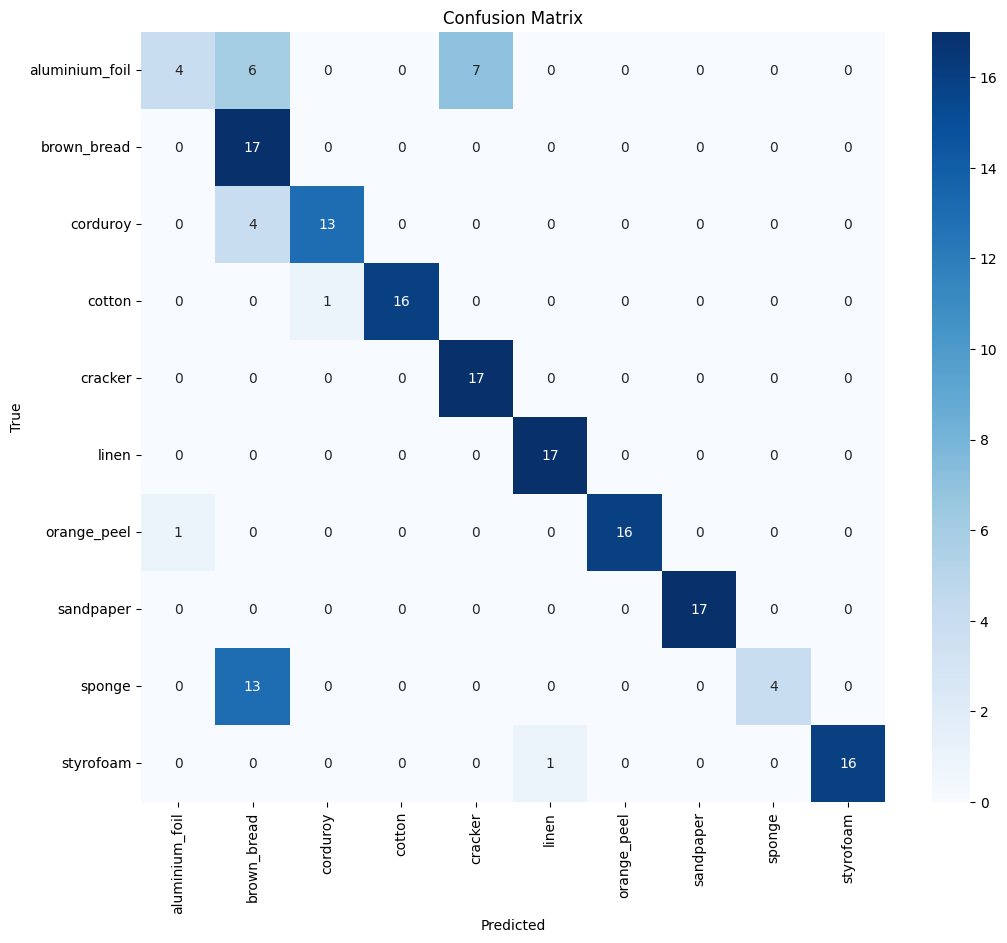

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


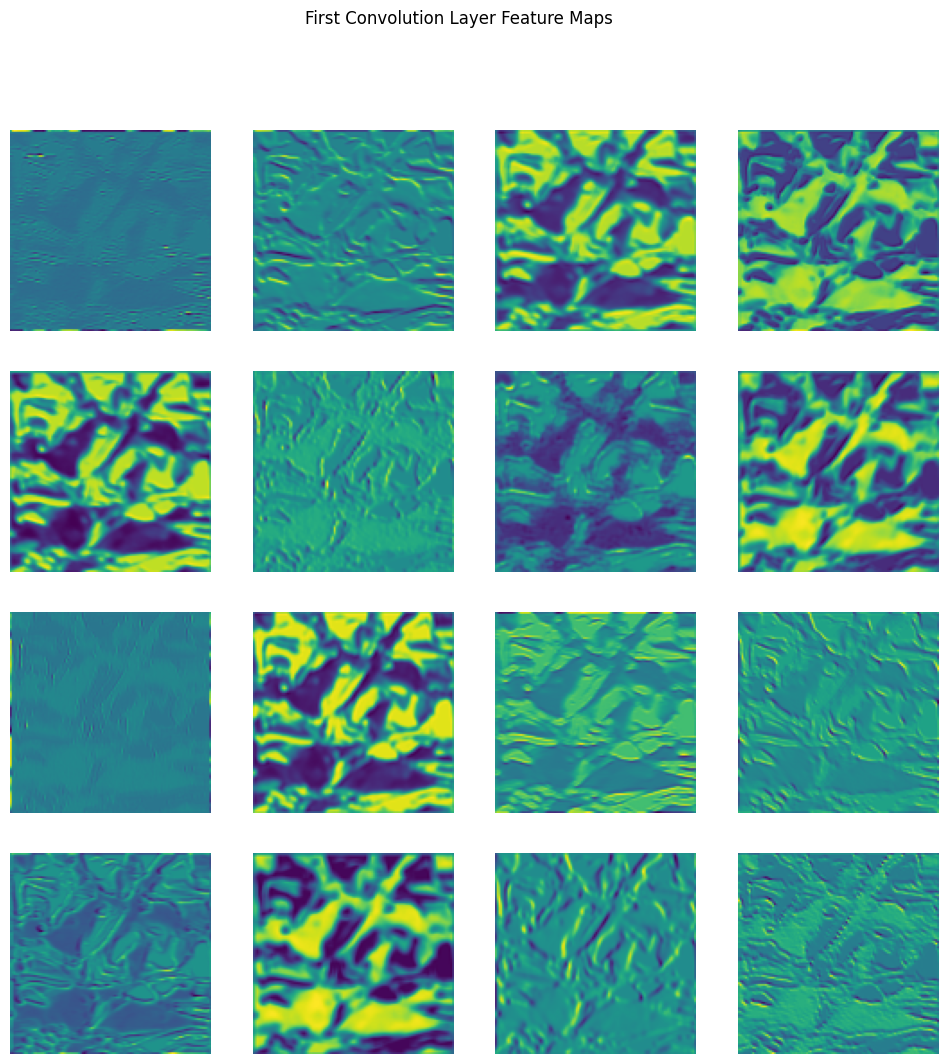

In [19]:
def visualize_feature_maps(model, image):
    model.eval()
    x = image.unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.conv1(x)  # first conv layer
    features = features.cpu()
    fig, axes = plt.subplots(4,4, figsize=(12,12))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(features[0,i].numpy(), cmap='viridis')
        ax.axis('off')
    plt.suptitle("First Convolution Layer Feature Maps")
    plt.show()

# Visualize feature maps of first image
visualize_feature_maps(model, train_dataset[0][0])
